In [229]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')

## Read in ALL THE DATA


In [230]:
use = pd.read_csv('eurostat/Water_Use_Data_RBD.csv', )
plant = pd.read_csv('eurostat/Treatment_plants_by_type_of_treatment_and_RBD.csv')
abstr = pd.read_csv('eurostat/Water_Abstraction_Data_RBD.csv')
waste = pd.read_csv('eurostat/Wastewater_generation_and_discharge_by_RBD.csv')
treat = pd.read_csv('eurostat/Treatment_capacity_of_wastewater_treatment_plants_by_RBD.csv')
pop = pd.read_csv('eurostat/Population_connected_to_wastewater_collection_and_treatment_systems_by_RBD.csv')
fresh = pd.read_csv('eurostat/Freshwater_Resources_Data.csv')

## ... and dust it ...

In [231]:
vals = ['use','plant','abstr','waste','treat','pop','fresh']
countries = {'BG' : 'Bulgaria', 
             'RO' : 'Romania', 
             'SI' : 'Slovenia', 
             'CH' : 'Switzerland', 
             'RS' : 'Serbia', 
             'CZ' : 'Czech Republic', 
             'DE' : 'Germany', 
             'HR' : 'Croatia', 
             'HU' : 'Hungary', 
             'AT' : 'Austria', 
             'SK' : 'Slovakia',
             'PL' : 'Poland'}


cols = [['NACE_R2','WAT_PROC'],
        ['WW_TP','WW_TPAR'],
        ['WAT_PROC','WAT_SRC'],
        ['WW_GTD','SUBSTANCE'],
        ['WW_TPAR','WW_TP'],
        ['WW_TP'],
        ['WAT_PROC'],]

for idx, i in enumerate(vals):   
    v = vars()[i]
    v[v.Value == ':'] = np.nan
    v.drop('Flag and Footnotes',axis=1,inplace=True)
    v.dropna(subset=['Value'],inplace=True)
    v.set_index(['RBD'],inplace=True,append=True)
    v.set_index(['UNIT'],inplace=True,append=True)
    v.set_index(cols[idx],inplace=True,append=True)
    vars()[i] = v


In [232]:
use.head()

,,,,,TIME,Value
,RBD,UNIT,NACE_R2,WAT_PROC,,
0,Belgium,Million cubic metres,"Agriculture, forestry and fishing",Public water supply and self and other supply,2000.0,52.1
1,Belgium,Million cubic metres,Industry and construction,Public water supply and self and other supply,2000.0,6563.9
2,Belgium,Million cubic metres,Services,Public water supply and self and other supply,2000.0,398.4
3,Belgium,Million cubic metres,Households,Public water supply and self and other supply,2000.0,422.2
4,Belgium,Million cubic metres,All NACE activities plus households,Public water supply and self and other supply,2000.0,7436.6


## Now get all the data for some river, say,  Danube (Donau):

In [233]:
river = 'Morava'

In [234]:
for v in vals:
    x = vars()[v].index.get_level_values('RBD').str.contains(river)
    vars()[v] = vars()[v][x]
    if vars()[v].size == 0:
        print('{} is empty.'.format(v))

## Get all available observables

In [235]:
p = pd.Series()
d = pd.Series()
sub = pd.Series()
for i, v in enumerate(vals):
    for idx in cols[i]:
        x = list(set(vars()[v].index.get_level_values(idx)))
        sub = sub.append(pd.Series([idx]*len(x)),
                ignore_index=True)
        p = p.append(pd.Series(x),
                ignore_index=True)
        d = d.append(pd.Series([v]*len(x)),
                    ignore_index=True)
params = pd.DataFrame({'DataSet':d,'DataSetColumn':sub,'Parameter':p})
params.head(4)

,DataSet,DataSetColumn,Parameter
0,use,NACE_R2,"Agriculture, forestry and fishing"
1,use,NACE_R2,Households
2,use,NACE_R2,Services
3,use,NACE_R2,All NACE activities plus households


## Which countries do we find data on Danube in?

In [236]:
l = []
for i, v in enumerate(vals):
    l.append(list(set(vars()[v].index.get_level_values('RBD').values)))
danube = list(set([i for item in l for i in item]))
rem = [item for item in danube if ('RBD' not in item)]
for i in rem:
    danube.remove(i) 

ds = [item[-3:-1] for item in danube]
[countries[i] for i in ds]

[]

## Create files for all regions containing time-domain info on each available parameter:

In [180]:
header = params.Parameter.tolist()
for i, dan in enumerate(danube):
    db = pd.DataFrame(index=np.arange(2000,2016))
    for i, row in params.iterrows():
        df = vars()[row.DataSet]
        subdata = df[(df.index.get_level_values(row.DataSetColumn)==row.Parameter) & (df.index.get_level_values('RBD')==dan)]
        units = list(set(subdata.index.get_level_values('UNIT').values))
        if units != []:
            for unit in units:
                ssub = subdata[subdata.index.get_level_values('UNIT') == unit]
                time = ssub.TIME.tolist()
                values = ssub.Value.astype(float).tolist()
                s = pd.DataFrame({'time':time,'values':values})
                s = s.groupby('time').mean()
                db['{} ({})'.format(row.Parameter,unit)] = s
    db.to_csv('Danube/{}.csv'.format(dan[-3:-1]))

## Now create river-dependent files for custom parameters ...

In [184]:
water = pd.DataFrame()
for idx in ds:
    d =  pd.read_csv('Danube/{}.csv'.format(idx),index_col=0)
    try:
        f = d[['Fresh surface water (Million cubic metres)','Fresh groundwater (Million cubic metres)']]
        f['ID'] = countries[idx]
        f = f.set_index('ID',append=True)
        water = water.append(f)
    except KeyError:
        pass

water.to_csv('Danube/water_resources.csv')

## ... or find correlations between parameters for selected regions ...

In [215]:

def color_red(val):
    """
    Takes a scalar and returns a string with
    the css property `'color: red'` for negative
    strings, black otherwise.
    """
    color = 'red' if type(val) == str else 'black'
    return 'color: %s' % color



d =  pd.read_csv('Danube/{}.csv'.format('SK'),index_col=0)
corr = d.corr(min_periods=12).dropna(axis=1,how='all').dropna(axis=0,how='all')
corr[((corr < 1.) & (corr > 0.7))] = 2.
corr[corr == 2.] = 'Correlation!'

corr.style.applymap(color_red)

,Water abstraction for agriculture - irrigation (Million cubic metres),Water abstraction for public water supply (Million cubic metres),Total gross abstraction (Million cubic metres),Fresh groundwater (Million cubic metres),Fresh surface water (Million cubic metres)
Water abstraction for agriculture - irrigation (Million cubic metres),1,0.474672,0.602532,0.422761,0.637134
Water abstraction for public water supply (Million cubic metres),0.474672,1,Correlation!,Correlation!,Correlation!
Total gross abstraction (Million cubic metres),0.602532,Correlation!,1,0.653247,Correlation!
Fresh groundwater (Million cubic metres),0.422761,Correlation!,0.653247,1,0.615552
Fresh surface water (Million cubic metres),0.637134,Correlation!,Correlation!,0.615552,1


## ... plot stuff ...

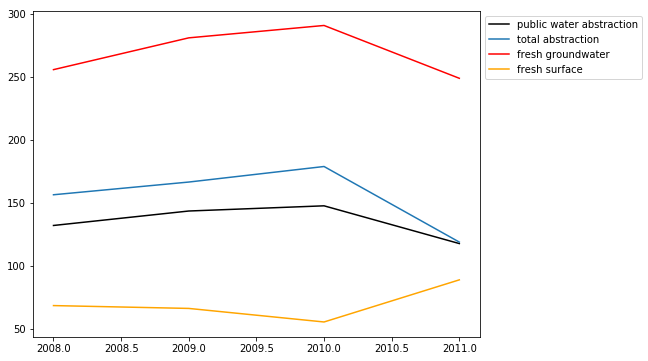

In [220]:
plt.figure(figsize=(8,6))
plt.plot(sk.index.values,
        sk['Water abstraction for public water supply (Million cubic metres)'],
        color = 'k',
        label = 'public water abstraction')
plt.plot(sk.index.values,
        sk['Total gross abstraction (Million cubic metres)'],
        label = 'total abstraction')
plt.plot(sk.index.values,
        sk['Fresh groundwater (Million cubic metres)'],
        label = 'fresh groundwater',
        color = 'red')
plt.plot(sk.index.values,
        sk['Fresh surface water (Million cubic metres)'],
        label = 'fresh surface',
        color = 'orange')
plt.legend(bbox_to_anchor=(1, 1))
plt.show()

In [237]:
import plotly as py
import plotly.graph_objs as go

df_d = pd.read_csv('Danube/water_resources.csv', index_col = [0, 1])

df_d.loc[df_d.index.get_level_values(0) == 2001, 'Fresh surface water (Million cubic metres)']

for year in np.arange(2000,2016):
    vars()['df_d' + str(year)] = df_d[df_d.index.get_level_values(0) == year]

for year in np.arange(2000,2016):
    vars()['data' + str(year)] = dict (
        type = 'choropleth',
        locations = df_d.index.get_level_values('ID').unique(),
        locationmode='country names',
    #   colorscale = [1,2,3],
        z = df_d.loc[df_d.index.get_level_values(0) == year, 'Fresh surface water (Million cubic metres)']
    )
    
    vars()['lyt' + str(year)]= dict(geo=dict(scope='europe'),
            title = 'Fresh surface water (Million cubic metres) in ' + str(year)
        )
    vars()['map' + str(year)] = go.Figure(data=[vars()['data' + str(year)]], layout = vars()['lyt' + str(year)])
    
    py.offline.plot(vars()['map' + str(year)], filename = 'map'+str(year)+'.html')

ImportError: No module named 'plotly'